In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50, decode_predictions, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
from scipy.optimize import fmin_l_bfgs_b
from tensorflow.keras.models import load_model

In [ ]:
def shuffle_in_unison_scary(a,b,c):#function to shuffle the arrays in unison(to choose random samples)
    rng_state = np.random.get_state()
    np.random.shuffle(a)
    np.random.set_state(rng_state)
    np.random.shuffle(b)
    np.random.set_state(rng_state)
    np.random.shuffle(c)

In [ ]:
  
model=load_model('/content/gdrive/My Drive/models/sp_model_15_softmax2.h5')#trained model

#function to preprocess image   
def preprocess_img(image):
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, (224, 224))
    image = preprocess_input(image)
    image = image[None, ...]
    
    return image

#for reverse pre-process
def restore_original_image_from_array(x, data_format='channels_last'):
    mean = [103.939, 116.779, 123.68]

    # Zero-center by mean pixel
    if data_format == 'channels_first':
        if x.ndim == 3:
            x[0, :, :] += mean[0]
            x[1, :, :] += mean[1]
            x[2, :, :] += mean[2]
        else:
            x[:, 0, :, :] += mean[0]
            x[:, 1, :, :] += mean[1]
            x[:, 2, :, :] += mean[2]
    else:
        x[..., 0] += mean[0]
        x[..., 1] += mean[1]
        x[..., 2] += mean[2]

    if data_format == 'channels_first':
        # 'BGR'->'RGB'
        if x.ndim == 3:
            x = x[::-1, ...]
        else:
            x = x[:, ::-1, ...]
    else:
        # 'BGR'->'RGB'
        x = x[..., ::-1]

    return x



def reverse_preprocess(p_img,a_numpy=True):
    if a_numpy:
      p_img=p_img.numpy()
    ip_img=restore_original_image_from_array(p_img, data_format='channels_last')
    ia_img=array_to_img(ip_img[0])
    img=ia_img
    return img

#helper function to display images
def l_display_images(model,image,description,savepath=None,save=False,single_img=True,categorical=True):

    classes={0:'Unaffected',1:'DR Affected'}
    i=0
    if (single_img==False):
      for img in image:
        preds=model.predict(img)
        if categorical:
            label=np.argmax(preds)
            class_confidence=preds[i][label]
        else:
            label = (preds > 0.5).reshape(1).astype(np.int)[0]
            class_confidence=preds.reshape(1).astype(np.float32)[0]
        
        print(label)
        image_class=classes[label]
      
        print("result",label,image_class, class_confidence)

        img=reverse_preprocess(img)
        plt.figure()
        plt.imshow(img)
        plt.title('{} \n {} : {:.2f}%'.format(description,
                                                        image_class,class_confidence*100))
        plt.show()
        if save:
          path=savepath+'img{}'.format(i)
          save_img(path)
        i=i+1
        print('completed')
    else:

      preds=model.predict(image)
      if categorical:
          label=np.argmax(preds)
          class_confidence=preds[0][label]
      else:
          label = (preds > 0.5).reshape(1).astype(np.int)[0]
          class_confidence=preds.reshape(1).astype(np.float32)[0]
        
      print(label)
      image_class=classes[label]
      print("result",preds,image_class, class_confidence)

      img=reverse_preprocess(image)
      plt.figure()
      plt.imshow(img)
      plt.title('{} \n {} : {:.2f}%'.format(description,
                                                      image_class,class_confidence*100))
      plt.show()
      if save:
        path=savepath+'img{}'.format(i)
        save_img(path)



In [ ]:
with np.load('/content/gdrive/My Drive/models/sp_test_conf.npz') as data:#data to test the attacks
    dataset = data["dataset"]
    labels = data["labels"]
    conf=data['conf']


shuffle_in_unison_scary(dataset,labels,conf)
#np.random.shuffle(dataset)
#np.random.shuffle(labels)
#np.random.shuffle(conf)
print(dataset.shape)

(283, 224, 224, 3)


use this as loss function for distillation

In [ ]:
def fn(correct, predicted,train_temp=100): 
    return tf.nn.softmax_cross_entropy_with_logits(labels=correct,
                                                    logits=predicted/train_temp)

Preparing dataset

In [ ]:
x=[]
y=[]
confidence=[]
i=0
a=0
b=0
c=0
dataset=tf.convert_to_tensor(dataset)
preds=model(dataset)
for i in range(55):
     #print(i)
     if labels[i]==0:
       a=a+1#class 0
     else:
       b=b+1 #class 1
     label=np.argmax(preds[i])
     class_confidence=preds[i][label]
     conf=class_confidence*100
     if (label!=labels[i]):#to count and neglect wrong labels
        c=c+1
        continue 
     x.append(dataset[i])
     confidence.append(conf) 
     y.append(labels[i])
     
print(a,b,c)

31 24 4


In [ ]:
x=np.asarray(x)
y=np.asarray(y)
confidence=np.asarray(confidence)
print(x.shape,y.shape,confidence.shape)

(51, 224, 224, 3) (51,) (51,)


In [ ]:
#preparing target labels
t_labels=np.zeros(y.shape)
for i in range(50):
    t=1-y[i]
    t_labels[i]=t

In [ ]:
#preparing processed images 
p_img=np.zeros(x.shape)
for i in range(50):
  p_img[i]=preprocess_img(x[i])

#p_img=tf.convert_to_tensor(p_img)
p_img=tf.cast(p_img,dtype=tf.float32)
print(p_img.dtype)

<dtype: 'float32'>


Minimum distortion attack

In [ ]:
"""The CarliniWagnerL2 attack.
"""
import numpy as np
import tensorflow as tf


def carlini_wagner_l2(model_fn, x, **kwargs):
    """
    This is the function interface for the Carlini-Wagner-L2 attack.
    For more details on the attack and the parameters see the corresponding class.
    """
    return CarliniWagnerL2(model_fn, **kwargs).attack(x)


class CarliniWagnerL2Exception(Exception):
    pass


class CarliniWagnerL2(object):
    def __init__(
        self,
        model_fn,
        y=None,
        targeted=False,
        batch_size=1,
        clip_min=0.0,
        clip_max=1.0,
        binary_search_steps=5,
        max_iterations=1000,
        abort_early=True,
        confidence=100,
        initial_const=1e-3,
        learning_rate=1e-3,
    ):
        """
        This attack was originally proposed by Carlini and Wagner. It is an
        iterative attack that finds adversarial examples on many defenses that
        are robust to other attacks.
        Paper link: https://arxiv.org/abs/1608.04644
        At a high level, this attack is an iterative attack using Adam and
        a specially-chosen loss function to find adversarial examples with
        lower distortion than other attacks. This comes at the cost of speed,
        as this attack is often much slower than others.
        :param model_fn: a callable that takes an input tensor and returns the model logits.
        :param y: (optional) Tensor with target labels.
        :param targeted: (optional) Targeted attack?
        :param batch_size (optional): Number of attacks to run simultaneously.
        :param clip_min: (optional) float. Minimum float values for adversarial example components.
        :param clip_max: (optional) float. Maximum float value for adversarial example components.
        :param binary_search_steps (optional): The number of times we perform binary
                                search to find the optimal tradeoff-
                                constant between norm of the purturbation
                                and confidence of the classification.
        :param max_iterations (optional): The maximum number of iterations. Setting this
                               to a larger value will produce lower distortion
                               results. Using only a few iterations requires
                               a larger learning rate, and will produce larger
                               distortion results.
        :param abort_early (optional): If true, allows early aborts if gradient descent
                        is unable to make progress (i.e., gets stuck in
                        a local minimum).
        :param confidence (optional): Confidence of adversarial examples: higher produces
                           examples with larger l2 distortion, but more
                           strongly classified as adversarial.
        :param initial_const (optional): The initial tradeoff-constant used to tune the
                          relative importance of the size of the perturbation
                          and confidence of classification.
                          If binary_search_steps is large, the initial
                          constant is not important. A smaller value of
                          this constant gives lower distortion results.
        :param learning_rate (optional): The learning rate for the attack algorithm.
                          Smaller values produce better results but are
                          slower to converge.
        """
        self.model_fn = model_fn

        self.batch_size = batch_size

        self.y = y
        self.targeted = y is not None

        self.clip_min = clip_min
        self.clip_max = clip_max

        self.binary_search_steps = binary_search_steps
        self.max_iterations = max_iterations
        self.abort_early = abort_early
        self.learning_rate = learning_rate

        self.confidence = confidence
        self.initial_const = initial_const

        # the optimizer
        self.optimizer = tf.keras.optimizers.Adam(self.learning_rate)

        super(CarliniWagnerL2, self).__init__()

    def attack(self, x):
        """
        Returns adversarial examples for the tensor.
        :param x: input tensor.
        :return: a numpy tensor with the adversarial example.
        """
        adv_ex = np.zeros_like(x)
        y=self.y
        print(y.shape)
        """for i in range(0, len(x), self.batch_size):
            adv_ex[i : i + self.batch_size] = self._attack(
                x[i : i + self.batch_size],
                y[i :  i + self.batch_size]
            ).numpy()
        #self._attack(x)"""

        return self._attack(x,self.y)#modified to run with single image alone

    def _attack(self, x,y):
        """if self.clip_min is not None:
            if not np.all(tf.math.greater_equal(x, self.clip_min)):
                print(np.max(x),self.clip_min)
                raise CarliniWagnerL2Exception(
                    f"The input is smaller than the minimum value of {self.clip_min}r"
                )

        if self.clip_max is not None:
            if not np.all(tf.math.less_equal(x, self.clip_max)):
                raise CarliniWagnerL2Exception(
                    f"The input is greater than the maximum value of {self.clip_max}!"
                )"""

        y, _ = get_or_guess_labels(self.model_fn, x, y=y, targeted=self.targeted)

        # cast to tensor if provided as numpy array
        original_x = tf.cast(x, tf.float32)
        shape = original_x.shape

        if not y.shape.as_list()[0] == original_x.shape.as_list()[0]:
            print(original_x.shape,y.shape)
            raise CarliniWagnerL2Exception("x and y do not have the same shape!")

        # re-scale x to [0, 1]
        x = original_x
        x = (x - self.clip_min) / (self.clip_max - self.clip_min)
        x = tf.clip_by_value(x, 0.0, 1.0)

        # scale to [-1, 1]
        x = (x * 2.0) - 1.0

        # convert tonh-space
        x = tf.atanh(x * 0.999999)

        # parameters for the binary search
        lower_bound = tf.zeros(shape[:1])
        upper_bound = tf.ones(shape[:1]) * 1e10

        const = tf.ones(shape) * self.initial_const

        # placeholder variables for best values
        best_l2 = tf.fill(shape[:1], 1e10)
        best_score = tf.fill(shape[:1], -1)
        best_score = tf.cast(best_score, tf.int32)
        best_attack = original_x
        best_loss=tf.fill(shape[:1],1e10)

        # convience function for comparing
        compare_fn = tf.equal if self.targeted else tf.not_equal

        # the perturbation
        modifier = tf.Variable(tf.zeros(shape, dtype=x.dtype), trainable=True)

        for outer_step in range(self.binary_search_steps):
            # at each iteration reset variable state
            modifier.assign(tf.zeros(shape, dtype=x.dtype))
            for var in self.optimizer.variables():
                var.assign(tf.zeros(var.shape, dtype=var.dtype))

            # variables to keep track in the inner loop
            current_best_l2 = tf.fill(shape[:1], 1e10)
            current_best_score = tf.fill(shape[:1], -1)
            current_best_score = tf.cast(current_best_score, tf.int32)
            
            print(' current_l2 ',best_l2,' ',outer_step)

            # The last iteration (if we run many steps) repeat the search once.
            if (
                self.binary_search_steps >= 10
                and outer_step == self.binary_search_steps - 1
            ):
                const = upper_bound

            # early stopping criteria
            prev = None
            print('const',tf.reduce_max(const).numpy())
            for iteration in range(self.max_iterations):
                x_new=x
                l_modifier=modifier
                x_new, loss, preds, l2_dist = self.attack_step(x_new, y, modifier, const)
                print('iteration',iteration,' ',loss,' ',l2_dist)
                # check if we made progress, abort otherwise
                if (
                    self.abort_early
                    and iteration % ((self.max_iterations // 10) or 1) == 0
                ):
                    if prev is not None and loss > prev * 0.9999:
                        print("early stop")
                        break


                    prev = loss
                #target lable
                lab = tf.argmax(y, axis=1)

                pred_with_conf = (
                    preds - self.confidence
                    if self.targeted
                    else preds + self.confidence
                )
                pred_with_conf = tf.argmax(pred_with_conf, axis=1)
                #predicted lable
                pred = tf.argmax(preds, axis=1)
                pred = tf.cast(pred, tf.int32)

                # compute a binary mask of the tensors we want to assign, this mask checks if the obtained l2 distance is less than current l2
                #if yes, we need to update our values with the found adversary
                mask = tf.math.logical_and(
                    tf.less(l2_dist, current_best_l2), compare_fn(pred_with_conf, lab)
                )

                # all entries which evaluate to True get reassigned
                current_best_l2 = set_with_mask(current_best_l2, l2_dist, mask)
                current_best_score = set_with_mask(current_best_score, pred, mask)

                # if the l2 distance is better than the one found before
                # and if the example is a correct example (with regards to the labels)
                mask = tf.math.logical_and(
                    tf.less(l2_dist, best_l2), compare_fn(pred_with_conf, lab)
                )

                best_l2 = set_with_mask(best_l2, l2_dist, mask)
                best_score = set_with_mask(best_score, pred, mask)

                # mask is of shape [batch_size]; best_attack is [batch_size, image_size]
                # need to expand
                mask = tf.reshape(mask, [-1, 1, 1, 1])
                mask = tf.tile(mask, [1, *best_attack.shape[1:]])

                #best attack holds the currently found best adversarial image
                best_attack = set_with_mask(best_attack, x_new, mask)


            # adjust binary search parameters(to find optimal constant c)
            lab = tf.argmax(y, axis=1)
            lab = tf.cast(lab, tf.int32)

            # we first compute the mask for the upper bound
            upper_mask = tf.math.logical_and(
                compare_fn(best_score, lab),
                tf.not_equal(best_score, -1),
            )
            upper_bound = set_with_mask(
                upper_bound, tf.math.minimum(upper_bound, const), upper_mask
            )

            # based on this mask compute const mask
            const_mask = tf.math.logical_and(
                upper_mask,
                tf.less(upper_bound, 1e9),
            )
            const = set_with_mask(const, (lower_bound + upper_bound) / 2.0, const_mask)

            # else case is the negation of the inital mask
            lower_mask = tf.math.logical_not(upper_mask)
            lower_bound = set_with_mask(
                lower_bound, tf.math.maximum(lower_bound, const), lower_mask
            )

            const_mask = tf.math.logical_and(
                lower_mask,
                tf.less(upper_bound, 1e9),
            )
            const = set_with_mask(const, (lower_bound + upper_bound) / 2, const_mask)

            const_mask = tf.math.logical_not(const_mask)
            const = set_with_mask(const, const * 10, const_mask)

        return best_attack,best_score

    def attack_step(self, x, y, modifier, const):
       #computes gradient 
        x_new, grads, loss, preds, l2_dist = self.gradient(x, y, modifier, const)
        #adam optimizer is called to apply the gradients found
        self.optimizer.apply_gradients([(grads, modifier)])
        return x_new, loss, preds, l2_dist

    @tf.function
    def gradient(self, x, y, modifier, const):
        # compute the actual attack
        with tf.GradientTape() as tape:
            adv_image = modifier + x
            tape.watch(adv_image)
            x_new = clip_tanh(adv_image, clip_min=self.clip_min, clip_max=self.clip_max)
            preds = self.model_fn(x_new)

            real = tf.reduce_sum(y * preds, 1) #logit value of this class
            other = tf.reduce_max((1.0 - y) * preds- y * 10_000, 1) #other highest logit class
            #computing their diff
            loss_1 = tf.maximum(0.0, other - real + self.confidence)
            other=clip_tanh(x, clip_min=self.clip_min, clip_max=self.clip_max)
            #norm 
            l2_dist=l2(x_new,other)
            loss_2 = tf.reduce_sum(l2_dist)
            #summing losses
            loss=loss_1+loss_2
            #this function does the same
            """loss, l2_dist = loss_fn(
                x=x,
                x_new=x_new,
                y_true=y,
                y_pred=preds,
                confidence=self.confidence,
                const=const,
                targeted=self.targeted,
                clip_min=self.clip_min,
                clip_max=self.clip_max,
            )"""

        grads = tape.gradient(loss, adv_image)
        return x_new, grads, loss, preds, l2_dist


def l2(x, y):
    # technically squarred l2
    return tf.reduce_sum(tf.square(x - y), list(range(1, len(x.shape))))

#to compute the loss
def loss_fn(
    x,
    x_new,
    y_true,
    y_pred,
    confidence,
    const=0,
    targeted=False,
    clip_min=0,
    clip_max=1,
):
    other = clip_tanh(x, clip_min=clip_min, clip_max=clip_max)
    l2_dist = l2(x_new, other)

    real = tf.reduce_sum(y_true * y_pred, 1)
    other = tf.reduce_max((1.0 - y_true) * y_pred - y_true * 10_000, 1)

    print('loss',real,' ',other)
    if targeted:
        # if targeted, optimize for making the other class most likely
        loss_1 = tf.maximum(0.0, other - real + confidence)
    else:
        # if untargeted, optimize for making this class least likely.
        loss_1 = tf.maximum(0.0, real - other + confidence)

    # sum up losses
    loss_2 = tf.reduce_sum(l2_dist)
    loss_1 = tf.reduce_sum(const * loss_1)
   # loss = loss_1 + loss_2
    print('loss2',loss_1,' ',loss_2)
    return loss1, l2_dist

#to conver to tanh space,refer formula
def clip_tanh(x, clip_min, clip_max):
    return ((tf.tanh(x) + 1) / 2) * (clip_max - clip_min) + clip_min

Helper functions

In [ ]:
#helper function to get labels for untargeted attack and convert label into one-hot for targeted
def get_or_guess_labels(model_fn, x, y=None, targeted=False):
    """
    Helper function to get the label to use in generating an
    adversarial example for x.
    If 'y' is not None, then use these labels.
    If 'targeted' is True, then assume it's a targeted attack
    and y must be set.
    Otherwise, use the model's prediction as the label and perform an
    untargeted attack
    :param model_fn: a callable that takes an input tensor and returns the model logits.
    :param x: input tensor.
    """
    if targeted is True and y is None:
        raise ValueError("Must provide y for a targeted attack!")

    preds = model_fn(x)
    nb_classes = preds.shape[-1]

    # labels set by the user
    if y is not None:
        # inefficient when y is a tensor, but this function only get called once
        y = np.asarray(y)

        if len(y.shape) == 1:
            # the user provided categorical encoding
            y = tf.one_hot(y, nb_classes)

        y = tf.cast(y, x.dtype)
        return y, nb_classes

    # must be an untargeted attack
    labels = tf.cast(
        tf.equal(tf.reduce_max(preds, axis=1, keepdims=True), preds), x.dtype
    )

    return labels, nb_classes

#function to apply the mask
def set_with_mask(x, x_other, mask):
    """Helper function which returns a tensor similar to x with all the values
    of x replaced by x_other where the mask evaluates to true.
    """
    mask = tf.cast(mask, x.dtype)
    ones = tf.ones_like(mask, dtype=x.dtype)
    return x_other * mask + x * (ones - mask)


Model (single image)


<dtype: 'float32'>
(1, 224, 224, 3)
1
tf.Tensor([[1. 0.]], shape=(1, 2), dtype=float32)


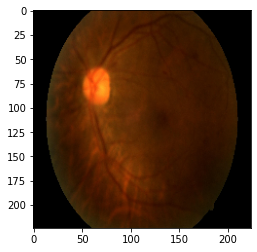

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50, decode_predictions, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array,array_to_img
import matplotlib.pyplot as plt
from scipy.optimize import fmin_l_bfgs_b
from scipy.optimize import minimize
from tensorflow.keras.models import Sequential,load_model

#model = ResNet50(include_top=True, weights="imagenet",classifier_activation=None)
#model.trainable = False

model=load_model('/content/gdrive/My Drive/models/sp_model_2_logits_temp.h5')
    
def preprocess_img(image):
    image = tf.cast(image, tf.float32)
    print(image.dtype)
    image = tf.image.resize(image, (224, 224))
    image = preprocess_input(image)
    image = image[None, ...]
    
    return image
    
#load and preprocess image
img = load_img('99_left.png', color_mode="rgb")
plt.imshow(img)
img = img_to_array(img)
img = preprocess_img(img)
print(img.shape)


preds = model.predict(img)
#preds=tf.nn.softmax(preds).numpy()
#cl, image_class, class_confidence = get_label(preds)
#print (cl,image_class, class_confidence)
print(np.argmax(preds))

#compute one-hot encoding of labels
y_adv_label = 0
y_adv = tf.one_hot(y_adv_label, preds.shape[-1])
y_adv = tf.reshape(y_adv, shape=[1, preds.shape[-1]])

print(y_adv)


Finding clip min and clip max values(change axis,for singl image)

In [ ]:
clip_min=tf.reduce_min(p_img,axis=[1,2,3])
clip_max=tf.reduce_max(p_img,axis=[1,2,3])
print(np.min(clip_min),np.max(clip_max))
#clip_min=np.min(clip_min)
#clip_max=np.max(clip_max)

-123.68 151.061


Running in loop(call 2 variants seperately)

1)carlini_wagner_l2

2)carlini_wagner_loss

In [ ]:
attack_imgs=[]
norms=[]
confs=[]
f_labels=[]
for i in range(51):
    adv_img,lab= carlini_wagner_loss(model,p_img[i:i+1],y=t_labels[i:i+1],clip_min=clip_min[i:i+1],clip_max=clip_max[i:i+1],targeted=True)
    norm=l2(adv_img,p_img[i:i+1])

    preds=tf.nn.softmax(model.predict(adv_img))
    f_label=np.argmax(preds,axis=1)
    print(preds,f_label)
    conf=np.max(preds,axis=1)*100
    print(conf)

    attack_imgs.append(adv_img)
    if (f_label == t_labels[i:i+1]):
      norms.append(norm)
      confs.append(conf)
    f_labels.append(f_label)
    print("done{}".format(i))

Streaming output truncated to the last 5000 lines.
iteration 50   tf.Tensor([0.], shape=(1,), dtype=float32)   tf.Tensor([180864.47], shape=(1,), dtype=float32)
iteration 51   tf.Tensor([0.], shape=(1,), dtype=float32)   tf.Tensor([181322.67], shape=(1,), dtype=float32)
iteration 52   tf.Tensor([0.], shape=(1,), dtype=float32)   tf.Tensor([181739.58], shape=(1,), dtype=float32)
iteration 53   tf.Tensor([0.], shape=(1,), dtype=float32)   tf.Tensor([182118.86], shape=(1,), dtype=float32)
iteration 54   tf.Tensor([0.], shape=(1,), dtype=float32)   tf.Tensor([182463.78], shape=(1,), dtype=float32)
iteration 55   tf.Tensor([0.], shape=(1,), dtype=float32)   tf.Tensor([182777.4], shape=(1,), dtype=float32)
iteration 56   tf.Tensor([0.], shape=(1,), dtype=float32)   tf.Tensor([183062.48], shape=(1,), dtype=float32)
iteration 57   tf.Tensor([0.], shape=(1,), dtype=float32)   tf.Tensor([183321.56], shape=(1,), dtype=float32)
iteration 58   tf.Tensor([0.], shape=(1,), dtype=float32)   tf.Tensor(

Printing results

In [ ]:
print(len(confs))
c=0
ind=[]
for i in range(51):
  if (f_labels[i]==t_labels[i]):
    c=c+1
    ind.append(i)
print(c)

51
21


In [ ]:
d=0
j=0
for i in range(len(confs)):
  if (confs[i]>confidence[ind[i]]):
    d=d+1
print(d)

In [ ]:
print(confs[0].shape)
conf_avg=np.average(confs)
conf_max=np.max(confs)
norm_avg=np.average(norms)
norm_max=np.max(norms)
norm_min=np.min(norms)
print(conf_avg,conf_max,norm_avg,norm_max,norm_min)

(1,)
nan nan nan nan nan


For single image(give appropriate parameters)

In [ ]:
#y=np.array(281).reshape(1)

adv_img,score=carlini_wagner_l2(model,p_img,y=t_labels,clip_min=clip_min,clip_max=clip_max,targeted=True,abort_early=False)

In [ ]:
preds=model(adv_img)

f_preds=tf.nn.softmax(preds)
print(f_preds)
#cl, image_class, class_confidence = get_label(preds)
#print (cl,image_class, class_confidence)
print(score)

tf.Tensor([[0.5634608  0.43653914]], shape=(1, 2), dtype=float32)
tf.Tensor([0], shape=(1,), dtype=int32)


following can be skipped(only for debugging)

In [ ]:
real = tf.reduce_sum(y_adv * preds, 1)
other = tf.reduce_max((1.0 - y_adv) * preds -(y_adv * 10_000), 1)
print(real,other)
loss1 = tf.maximum(0.0, other-real)
print(tf.reduce_sum(loss1* 0.0050000004))
loss2=l2(img,adv_img)
print(loss2)

tf.Tensor([-0.248022], shape=(1,), dtype=float32) tf.Tensor([-0.50324184], shape=(1,), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor([2055.3486], shape=(1,), dtype=float32)


In [ ]:
print(l2(img,adv_img))
np.linalg.norm([img,adv_img])

tf.Tensor([5064341.], shape=(1,), dtype=float32)


50155.332

In [ ]:
lab = tf.argmax(y_adv, axis=1)

pred_with_conf = (
    preds - confidence
)
pred_with_conf = tf.argmax(pred_with_conf, axis=1)

pred = tf.argmax(preds, axis=1)
pred = tf.cast(pred, tf.int32)

l2_dist=loss2
current_best_l2=tf.cast(20,dtype=tf.float32)

#compute a binary mask of the tensors we want to assign
mask = tf.math.logical_and(
    tf.less(l2_dist, current_best_l2), compare_fn(pred_with_conf, lab)
)
current_best_l2 = set_with_mask(current_best_l2, l2_dist, mask)

mask = tf.reshape(mask, [-1, 1, 1, 1])
mask = tf.tile(mask, [1, *adv_img.shape[1:]])
print(mask.shape)

best_attack = set_with_mask(img,adv_img, mask)

(tf.equal(best_attack,img))

Results

100% confidence, (1,0)
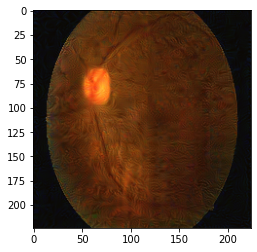

Confidence 56%,less distortion(2055)


tf.Tensor([[0.5634611  0.43653888]], shape=(1, 2), dtype=float32)
tf.Tensor([2055.3489], shape=(1,), dtype=float32)


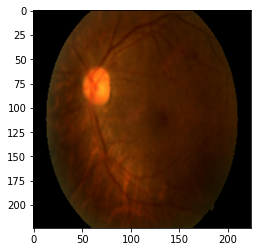

In [ ]:
print(f_preds)
print(loss2)
r_img=reverse_preprocess(adv_img)
plt.imshow(r_img)

77% confidence,More distortion(9091)

tf.Tensor([[0.77303535 0.22696464]], shape=(1, 2), dtype=float32)
tf.Tensor([9091.287], shape=(1,), dtype=float32)


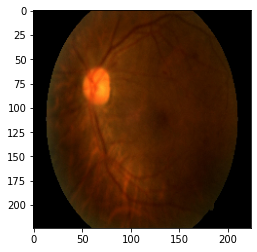

In [ ]:
print(f_preds)
print(loss2)
r_img=reverse_preprocess(adv_img)
plt.imshow(r_img)



Minimum loss attack(Modified the original code to look for minimum loss instead of minimum distortion, most code parts are same, just minor changes on the mask)



In [ ]:
"""The CarliniWagnerL2 attack.
"""
import numpy as np
import tensorflow as tf


def carlini_wagner_loss(model_fn, x, **kwargs):
    """
    This is the function interface for the Carlini-Wagner-L2 attack.
    For more details on the attack and the parameters see the corresponding class.
    """
    return CarliniWagner_loss(model_fn, **kwargs).attack(x)


class CarliniWagnerL2Exception(Exception):
    pass


class CarliniWagner_loss(object):
    def __init__(
        self,
        model_fn,
        y=None,
        targeted=False,
        batch_size=1,
        clip_min=0.0,
        clip_max=1.0,
        binary_search_steps=5,
        max_iterations=250,
        abort_early=True,
        confidence=100,
        initial_const=1e-3,
        learning_rate=1e-3,
    ):
        """
        This attack was originally proposed by Carlini and Wagner. It is an
        iterative attack that finds adversarial examples on many defenses that
        are robust to other attacks.
        Paper link: https://arxiv.org/abs/1608.04644
        At a high level, this attack is an iterative attack using Adam and
        a specially-chosen loss function to find adversarial examples with
        lower distortion than other attacks. This comes at the cost of speed,
        as this attack is often much slower than others.
        :param model_fn: a callable that takes an input tensor and returns the model logits.
        :param y: (optional) Tensor with target labels.
        :param targeted: (optional) Targeted attack?
        :param batch_size (optional): Number of attacks to run simultaneously.
        :param clip_min: (optional) float. Minimum float values for adversarial example components.
        :param clip_max: (optional) float. Maximum float value for adversarial example components.
        :param binary_search_steps (optional): The number of times we perform binary
                                search to find the optimal tradeoff-
                                constant between norm of the purturbation
                                and confidence of the classification.
        :param max_iterations (optional): The maximum number of iterations. Setting this
                               to a larger value will produce lower distortion
                               results. Using only a few iterations requires
                               a larger learning rate, and will produce larger
                               distortion results.
        :param abort_early (optional): If true, allows early aborts if gradient descent
                        is unable to make progress (i.e., gets stuck in
                        a local minimum).
        :param confidence (optional): Confidence of adversarial examples: higher produces
                           examples with larger l2 distortion, but more
                           strongly classified as adversarial.
        :param initial_const (optional): The initial tradeoff-constant used to tune the
                          relative importance of the size of the perturbation
                          and confidence of classification.
                          If binary_search_steps is large, the initial
                          constant is not important. A smaller value of
                          this constant gives lower distortion results.
        :param learning_rate (optional): The learning rate for the attack algorithm.
                          Smaller values produce better results but are
                          slower to converge.
        """
        self.model_fn = model_fn

        self.batch_size = batch_size

        self.y = y
        self.targeted = y is not None

        self.clip_min = clip_min
        self.clip_max = clip_max

        self.binary_search_steps = binary_search_steps
        self.max_iterations = max_iterations
        self.abort_early = abort_early
        self.learning_rate = learning_rate

        self.confidence = confidence
        self.initial_const = initial_const

        # the optimizer
        self.optimizer = tf.keras.optimizers.Adam(self.learning_rate)

        super(CarliniWagner_loss, self).__init__()

    def attack(self, x):
        """
        Returns adversarial examples for the tensor.
        :param x: input tensor.
        :return: a numpy tensor with the adversarial example.
        """
        adv_ex = np.zeros_like(x)
       # for i in range(0, len(x), self.batch_size):
        #    adv_ex[i : i + self.batch_size] = self._attack(
         #       x[i : i + self.batch_size]
         #   ).numpy()
        #self._attack(x)

        return self._attack(x)

    def _attack(self, x):
        """if self.clip_min is not None:
            if not np.all(tf.math.greater_equal(x, self.clip_min)):
                print(np.max(x),self.clip_min)
                raise CarliniWagnerL2Exception(
                    f"The input is smaller than the minimum value of {self.clip_min}r"
                )

        if self.clip_max is not None:
            if not np.all(tf.math.less_equal(x, self.clip_max)):
                raise CarliniWagnerL2Exception(
                    f"The input is greater than the maximum value of {self.clip_max}!"
                )"""

        y, _ = get_or_guess_labels(self.model_fn, x, y=self.y, targeted=self.targeted)

        # cast to tensor if provided as numpy array
        original_x = tf.cast(x, tf.float32)
        shape = original_x.shape

        if not y.shape.as_list()[0] == original_x.shape.as_list()[0]:
            raise CarliniWagnerL2Exception("x and y do not have the same shape!")

        # re-scale x to [0, 1]
        x = original_x
        x = (x - self.clip_min) / (self.clip_max - self.clip_min)
        x = tf.clip_by_value(x, 0.0, 1.0)

        # scale to [-1, 1]
        x = (x * 2.0) - 1.0

        # convert tonh-space
        x = tf.atanh(x * 0.999999)

        # parameters for the binary search
        lower_bound = tf.zeros(shape[:1])
        upper_bound = tf.ones(shape[:1]) * 1e10

        const = tf.ones(shape) * self.initial_const

        # placeholder variables for best values
        best_l2 = tf.fill(shape[:1], 1e10)
        best_score = tf.fill(shape[:1], -1)
        best_score = tf.cast(best_score, tf.int32)
        best_attack = original_x
        
        best_loss=tf.fill(shape[:1],1e10)#modified to compute the minimum loss found so far
        
        max_l2=tf.fill(shape[:1],1e4)
        # convience function for comparing
        compare_fn = tf.equal if self.targeted else tf.not_equal

        #added by us to do the checking and compare loss and norm
        def check_fn(l2_dist,current_best_l2,max_l2,loss,current_min_loss):
          if(tf.math.logical_and(tf.less(loss,current_min_loss),tf.less_equal(l2_dist,max_l2))):
            return True
          if(tf.equal(loss,current_min_loss)):
            if(tf.less(l2_dist,current_best_l2)):
              return True
          return False

        # the perturbation
        modifier = tf.Variable(tf.zeros(shape, dtype=x.dtype), trainable=True)
        
        #outer loop
        for outer_step in range(self.binary_search_steps):
            # at each iteration reset variable state
            modifier.assign(tf.zeros(shape, dtype=x.dtype))
            for var in self.optimizer.variables():
                var.assign(tf.zeros(var.shape, dtype=var.dtype))

            # variables to keep track in the inner loop
            current_best_l2 = tf.fill(shape[:1], 1e10)
            current_best_score = tf.fill(shape[:1], -1)
            current_best_score = tf.cast(current_best_score, tf.int32)
            current_min_loss= tf.fill(shape[:1],1e10)#modified by me to store the minimum loss
            
            print(' current_loss ',best_loss,' ',outer_step)

            # The last iteration (if we run many steps) repeat the search once.
            if (
                self.binary_search_steps >= 10
                and outer_step == self.binary_search_steps - 1
            ):
                const = upper_bound

            # early stopping criteria
            prev = None
            print('const',tf.reduce_max(const).numpy())
            for iteration in range(self.max_iterations):
                x_new=x
                l_modifier=modifier
                x_new, loss, preds, l2_dist = self.attack_step(x_new, y, modifier, const)
                print('iteration',iteration,' ',loss,' ',l2_dist)
      
                # check if we made progress, abort otherwise
                if (
                    self.abort_early
                    and iteration % ((self.max_iterations // 10) or 1) == 0
                ):
                    if prev is not None and loss > prev * 0.9999:
                        print("early stop")
                        break


                    prev = loss

                lab = tf.argmax(y, axis=1)

                pred_with_conf = (
                    preds - self.confidence
                    if self.targeted
                    else preds + self.confidence
                )
                pred_with_conf = tf.argmax(pred_with_conf, axis=1)

                pred = tf.argmax(preds, axis=1)
                pred = tf.cast(pred, tf.int32)

                # compute a binary mask of the tensors we want to assign(this mask is modified,to choose the minimum loss as opposed to minimum distortion)
                mask = tf.math.logical_and(
                    tf.less_equal(loss, current_min_loss),check_fn(l2_dist,current_best_l2,max_l2,loss,current_min_loss)
                )

                # all entries which evaluate to True get reassigned
                current_min_loss = set_with_mask(current_min_loss,loss, mask)
                current_best_l2 = set_with_mask(current_best_l2, l2_dist, mask)
                current_best_score = set_with_mask(current_best_score, pred, mask)

                # if the l2 distance is better than the one found before
                # and if the example is a correct example (with regards to the labels)
                mask = tf.math.logical_and(
                    tf.less_equal(loss,best_loss),check_fn(l2_dist,best_l2,max_l2,loss,best_loss)
                )

                best_loss = set_with_mask(best_loss,loss, mask)
                best_score = set_with_mask(best_score, pred, mask)
                best_l2 = set_with_mask(best_l2, l2_dist, mask)
                # mask is of shape [batch_size]; best_attack is [batch_size, image_size]
                # need to expand
                mask = tf.reshape(mask, [-1, 1, 1, 1])
                mask = tf.tile(mask, [1, *best_attack.shape[1:]])

                best_attack = set_with_mask(best_attack, x_new, mask)


            # adjust binary search parameters
            lab = tf.argmax(y, axis=1)
            lab = tf.cast(lab, tf.int32)

            # we first compute the mask for the upper bound
            upper_mask = tf.math.logical_and(
                compare_fn(best_score, lab),
                tf.not_equal(best_score, -1),
            )
            upper_bound = set_with_mask(
                upper_bound, tf.math.minimum(upper_bound, const), upper_mask
            )

            # based on this mask compute const mask
            const_mask = tf.math.logical_and(
                upper_mask,
                tf.less(upper_bound, 1e9),
            )
            const = set_with_mask(const, (lower_bound + upper_bound) / 2.0, const_mask)

            # else case is the negation of the inital mask
            lower_mask = tf.math.logical_not(upper_mask)
            lower_bound = set_with_mask(
                lower_bound, tf.math.maximum(lower_bound, const), lower_mask
            )

            const_mask = tf.math.logical_and(
                lower_mask,
                tf.less(upper_bound, 1e9),
            )
            const = set_with_mask(const, (lower_bound + upper_bound) / 2, const_mask)

            const_mask = tf.math.logical_not(const_mask)
            const = set_with_mask(const, const * 10, const_mask)

        return best_attack,best_loss

    def attack_step(self, x, y, modifier, const):
        x_new, grads, loss, preds, l2_dist = self.gradient(x, y, modifier, const)

        self.optimizer.apply_gradients([(grads, modifier)])
        return x_new, loss, preds, l2_dist

    @tf.function
    def gradient(self, x, y, modifier, const):
        # compute the actual attack
        with tf.GradientTape() as tape:
            adv_image = modifier + x
            tape.watch(adv_image)
            x_new = clip_tanh(adv_image, clip_min=self.clip_min, clip_max=self.clip_max)
            preds = self.model_fn(x_new)


            real = tf.reduce_sum(y * preds, 1)
            other = tf.reduce_max((1.0 - y) * preds- y * 10_000, 1)
            loss_1 = tf.maximum(0.0, other - real + self.confidence)
            other=clip_tanh(x, clip_min=self.clip_min, clip_max=self.clip_max)
            l2_dist=l2(x_new,other)
            loss_2 = tf.reduce_sum(l2_dist)

            loss=loss_1+loss_2
            """loss, l2_dist = loss_fn(
                x=x,
                x_new=x_new,
                y_true=y,
                y_pred=preds,
                confidence=self.confidence,
                const=const,
                targeted=self.targeted,
                clip_min=self.clip_min,
                clip_max=self.clip_max,
            )"""

        grads = tape.gradient(loss, adv_image)
        return x_new, grads, loss, preds, l2_dist


def l2(x, y):
    # technically squarred l2
    return tf.reduce_sum(tf.square(x - y), list(range(1, len(x.shape))))


def loss_fn(
    x,
    x_new,
    y_true,
    y_pred,
    confidence,
    const=0,
    targeted=False,
    clip_min=0,
    clip_max=1,
):
    other = clip_tanh(x, clip_min=clip_min, clip_max=clip_max)
    l2_dist = l2(x_new, other)

    real = tf.reduce_sum(y_true * y_pred, 1)
    other = tf.reduce_max((1.0 - y_true) * y_pred - y_true * 10_000, 1)

    print('loss',real,' ',other)
    if targeted:
        # if targeted, optimize for making the other class most likely
        loss_1 = tf.maximum(0.0, other - real + confidence)
    else:
        # if untargeted, optimize for making this class least likely.
        loss_1 = tf.maximum(0.0, real - other + confidence)

    # sum up losses
    loss_2 = tf.reduce_sum(l2_dist)
    loss_1 = tf.reduce_sum(const * loss_1)
   # loss = loss_1 + loss_2
    print('loss2',loss_1,' ',loss_2)
    return loss1, l2_dist


def clip_tanh(x, clip_min, clip_max):
    return ((tf.tanh(x) + 1) / 2) * (clip_max - clip_min) + clip_min